In [1]:
import os
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt

# necessary
from det_rnn import par, update_parameters 
from det_rnn import Stimulus
from det_rnn import Model

from utils.plotfnc import plot_trial, make_var_dict_figure

basedir = "D:\proj\det_rnn"

tf.__version__

'2.3.0-dev20200519'

In [2]:
# need to downgrade to cuda 10.1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Stimulus structure

In [3]:
par = update_parameters(par)
stimulus = Stimulus(par)   # the argument `par` may be omitted
trial_info = stimulus.generate_trial()

print(trial_info.keys())

# parameter has all parameters that you need
print(par.keys())

#stimulus
#print(stimulus.input_rule_rg)
#trial_info['neural_input'].shape # time? x trials/batch x neurons
#trial_info['mask'] # time? x trials/batch x neurons

dict_keys(['neural_input', 'stimulus_ori', 'desired_output', 'mask'])
dict_keys(['design', 'output_range', 'dead', 'mask', 'input_rule', 'output_rule', 'input_rule_strength', 'output_rule_strength', 'type', 'trial_per_subblock', 'stim_encoding', 'resp_decoding', 'exc_inh_prop', 'modular', 'connect_prob', 'dt', 'learning_rate', 'membrane_time_constant', 'input_mean', 'noise_in_sd', 'noise_rnn_sd', 'strength_input', 'strength_output', 'kappa', 'spike_regularization', 'spike_cost', 'weight_cost', 'clip_max_grad_val', 'masse', 'tau_fast', 'tau_slow', 'U_stf', 'U_std', 'n_iterations', 'iters_between_outputs', 'n_receptive_fields', 'n_tuned_input', 'n_tuned_output', 'n_ori', 'noise_mean', 'noise_sd', 'n_recall_tuned', 'n_hidden', 'batch_size', 'alpha_neuron', 'optimizer', 'loss_fun', 'design_rg', 'output_rg', 'dead_rg', 'input_rule_rg', 'output_rule_rg', 'n_rule_input', 'n_rule_output', 'n_input', 'n_output', 'n_timesteps', 'n_exc', 'EImodular_mask', 'rg_exc', 'rg_inh', 'w_in_mask', 'w_rnn_m

In [4]:
par['design']

{'iti': (0, 1.5), 'stim': (1.5, 3.0), 'delay': (3.0, 4.5), 'estim': (4.5, 6.0)}

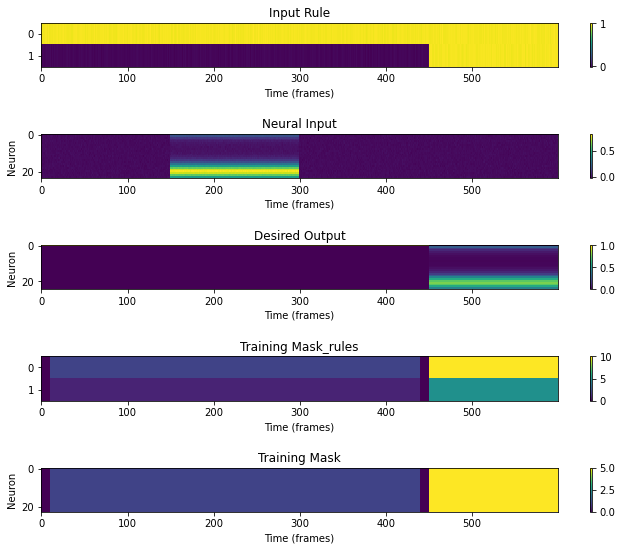

In [5]:
plot_trial(stimulus,trial_info)
# tuning output has different strengths?
# 'mask': {'iti'	: 1., 'stim' : 1., 'delay'	: 1., 'estim' : 5.,
        # 'rule_iti' : 2., 'rule_stim' : 2., 'rule_delay' : 2., 'rule_estim' : 10.},  # strengt

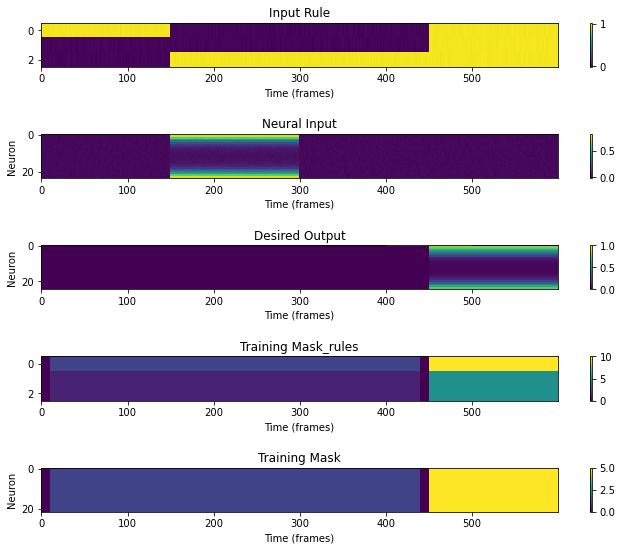

array([0.        , 0.8       , 0.7472975 , 0.6119573 , 0.44533432,
       0.29430357, 0.18168053, 0.10826822, 0.0645199 , 0.03982966],
      dtype=float32)

In [30]:
# try adding "motor" period
par['input_rule'] = {'fixation': ((0, 1.5),(4.5,6.0)),
                     'response': (4.5,6.0),
                     'motor': (1.5,6.0)}
par['output_rule'] = {'fixation': (4,5, 6.0)}

par = update_parameters(par)
stimulus = Stimulus(par)
trial_info = stimulus.generate_trial()

TEST_TRIAL = np.random.randint(stimulus.batch_size)
plot_trial(stimulus,trial_info, TEST_TRIAL=TEST_TRIAL)


trial_info['desired_output'][500, TEST_TRIAL, 0:10]

In [7]:
# back to orignal par.
from det_rnn import par

## Train model 

In [8]:
model = Model(par)

model

In [14]:
# train model
for iter in range(80):
    trial_info = stimulus.generate_trial()
    model(iter, trial_info['neural_input'], trial_info['desired_output'], trial_info['mask'])
    if iter % 10 == 0:
        model.print_results(iter)

Iter.    0 | Evaluaiton 0.0293 | Loss 480.6860 | Spike loss 84.0682
Iter.   10 | Evaluaiton 0.3333 | Loss 0.1391 | Spike loss 0.0024
Iter.   20 | Evaluaiton 0.3333 | Loss 0.1192 | Spike loss 0.0028
Iter.   30 | Evaluaiton 0.3333 | Loss 0.1159 | Spike loss 0.0031
Iter.   40 | Evaluaiton 0.3333 | Loss 0.1155 | Spike loss 0.0031
Iter.   50 | Evaluaiton 0.3333 | Loss 0.1155 | Spike loss 0.0032
Iter.   60 | Evaluaiton 0.3332 | Loss 0.1153 | Spike loss 0.0033
Iter.   70 | Evaluaiton 0.3310 | Loss 0.1152 | Spike loss 0.0035


In [15]:
# save model
filename = os.path.join(basedir,'output','model_200522')
pickle.dump(model, open(filename, 'wb'))

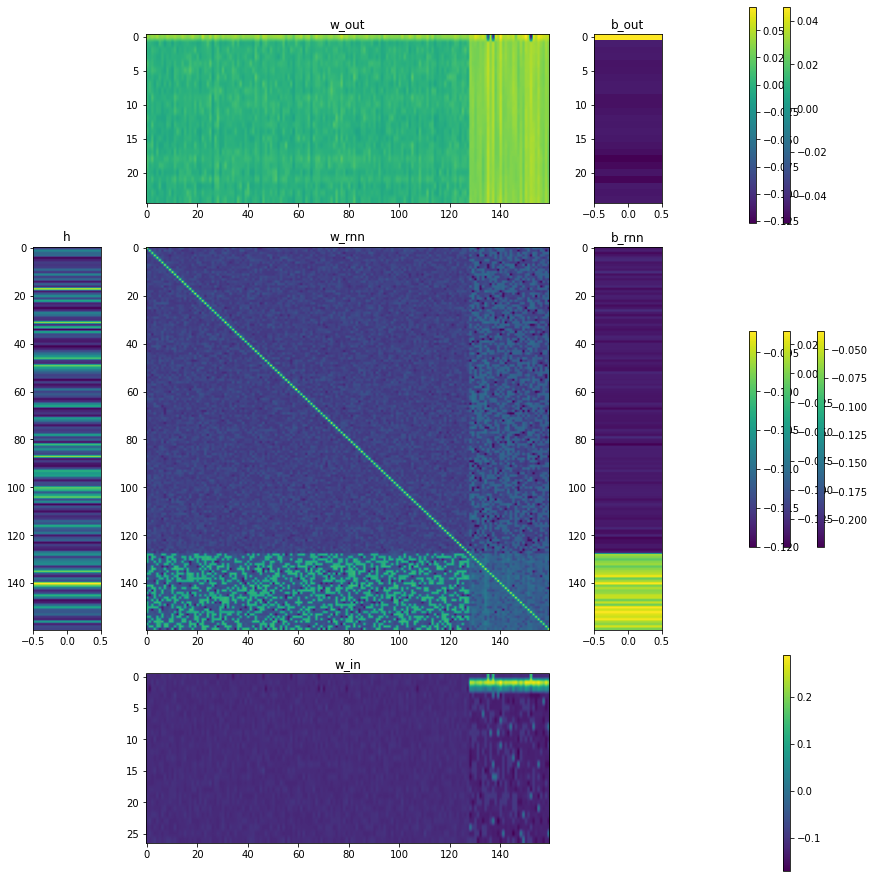

In [16]:
# plot model
make_var_dict_figure(model)

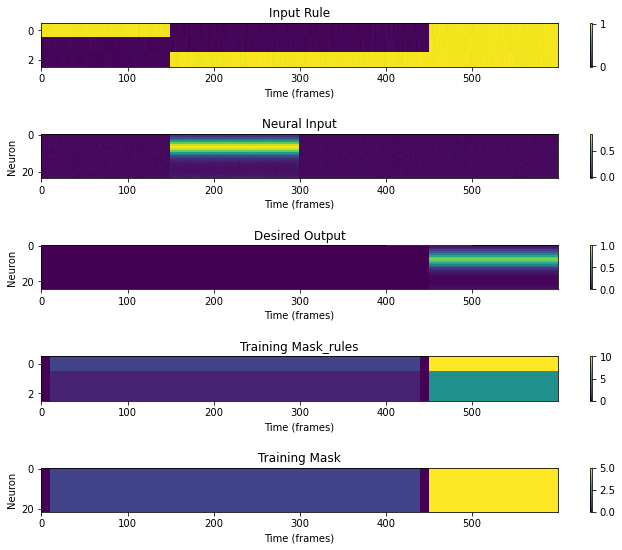

disc
(600, 25)
[1.         0.0645199  0.10826822 0.18168053 0.29430357 0.44533432
 0.6119573  0.7472975  0.8        0.7472975  0.6119573  0.44533432
 0.29430357 0.18168053 0.10826822 0.0645199  0.03982966 0.02632182
 0.01915495 0.01568587 0.01465251 0.01568587 0.01915495 0.02632182
 0.03982966]


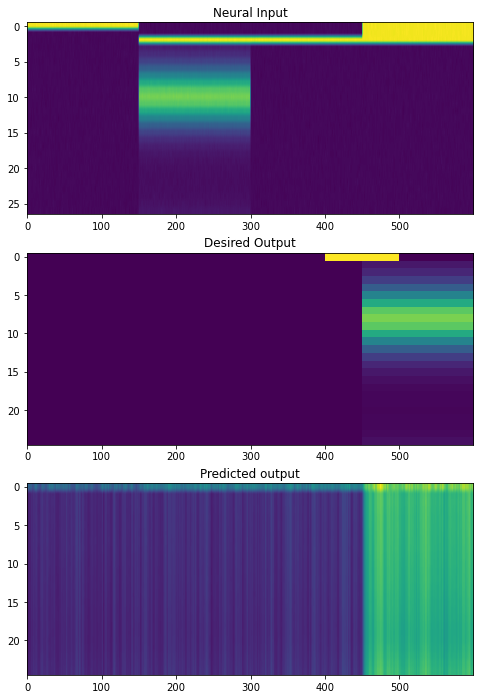

In [39]:
trial_info = stimulus.generate_trial() # need to save stimulus somewhere too?
pred_output = model.rnn_model(trial_info['neural_input'])

TEST_TRIAL = np.random.randint(stimulus.batch_size)
plot_trial(stimulus,trial_info, TEST_TRIAL=TEST_TRIAL)
print(par['resp_decoding'] )
print(trial_info['desired_output'][:,TEST_TRIAL,:].shape)
print(trial_info['desired_output'][480,TEST_TRIAL,:])

fig, axes = plt.subplots(3,1, figsize=(8,12))
axes[0].imshow(trial_info['neural_input'][:,TEST_TRIAL,:].T, aspect='auto'); axes[0].set_title("Neural Input")
if par['resp_decoding'] == 'conti':
    axes[1].plot(trial_info['desired_output'][:,TEST_TRIAL,:]); axes[1].set_ylim([-np.pi,np.pi]); axes[1].set_title("Desired Output")
    axes[2].plot(pred_output[0].numpy()[:,TEST_TRIAL,:]); axes[2].set_ylim([-np.pi,np.pi]); axes[2].set_title("Predicted output")
elif par['resp_decoding'] == 'disc':
    axes[1].imshow(trial_info['desired_output'][:,TEST_TRIAL,:].T, 
                   interpolation='none',
                   aspect='auto'); axes[1].set_title("Desired Output")
    axes[2].imshow(pred_output[0].numpy()[:,TEST_TRIAL,:].T, aspect='auto'); axes[2].set_title("Predicted output")    
plt.show()